# Building Health Index (BHI) - Root Cause Analysis & Simulation

## Warehouse/Fulfillment Center Performance Optimization

**Objective:** Identify root causes of poor BHI performance and simulate interventions to improve it.

**Causal Structure:**
- Root Causes: Forecast, Staffing, Storage Capacity, System Reliability
- Operations Flow: Receiving → Putaway → ASRS → Picking → Packing → Sortation → Shipping
- Outcome: Building Health Index (BHI)

**Analysis Workflow:**
1. Load and explore data
2. Define refined causal DAG
3. Train HT models
4. Identify root causes of anomalies
5. Simulate interventions
6. Generate actionable recommendations

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import json
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Import HT RCA and Simulation tools
import sys

from ht_categ import HT, HTConfig, CausalSimulator

print("✅ All imports successful!")

✅ All imports successful!


## 1. Load Data

**TODO: Update the file path to your BHI dataset**

In [2]:
# ============================================================================
# LOAD DATA - UPDATE THIS PATH
# ============================================================================

# TODO: Update this path to your actual data file
DATA_PATH = 'udm_1763133759721.csv'

df = pd.read_csv(DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1300, 33)

Columns: ['storageUtilizationPct', 'orders', 'realizedUnits', 'staffedHours', 'effectiveHours', 'uphBuilding', 'areaUnitsSortation', 'ophBuilding', 'buildingEffectiveHours', 'areaUnitsAsrs', 'targetOphBuilding', 'shifts', 'forecastUnits', 'staffedHeadcount', 'keyAssumptionVariance', 'areaUnitsPutaway', 'storagePallets', 'bulkShare', 'areaUnitsShipping', 'areaUnitsPacking', 'systemDowntimeHrs', 'nonconShare', 'buildingRealizedUnits', 'areaUnitsPicking', 'unitsPerVendorCarton', 'singlesShare', 'areaUnitsReceiving', 'buildingOrders', 'uphDept', 'ophDept', 'weekStart', 'department', 'buildingId']

First few rows:


,storageUtilizationPct,orders,realizedUnits,staffedHours,effectiveHours,uphBuilding,areaUnitsSortation,ophBuilding,buildingEffectiveHours,areaUnitsAsrs,targetOphBuilding,shifts,forecastUnits,staffedHeadcount,keyAssumptionVariance,areaUnitsPutaway,storagePallets,bulkShare,areaUnitsShipping,areaUnitsPacking,systemDowntimeHrs,nonconShare,buildingRealizedUnits,areaUnitsPicking,unitsPerVendorCarton,singlesShare,areaUnitsReceiving,buildingOrders,uphDept,ophDept,weekStart,department,buildingId
0,0.08,1144,2770.34,768,766.39,3.59,277.03,1.51,5958.29,481.61,520,2,2923.06,48.0,0.27,266.80,100.50,0.23,193.92,508.89,1.61,0.21,21370.00,737.34,11.97,0.69,304.74,8987,3.61,1.49,2024-11-18T00:00:00.000Z,Accessories,ATL_DC
1,4.87,977,2851.39,736,735.09,3.30,285.14,1.24,6279.92,505.03,520,2,2887.70,46.0,0.38,280.20,5841.82,0.29,199.60,518.18,0.91,0.18,20734.30,749.59,9.09,0.64,313.65,7799,3.88,1.33,2024-11-18T00:00:00.000Z,Accessories,BOS_DC
2,9.68,1277,3057.62,888,886.79,3.42,305.76,1.33,6089.03,536.44,520,3,2946.92,37.0,0.33,297.40,11615.52,0.26,214.03,558.73,1.21,0.17,20846.02,808.92,12.09,0.56,336.34,8118,3.45,1.44,2024-11-18T00:00:00.000Z,Accessories,CHI_DC
3,14.48,1271,2847.75,816,815.13,3.65,284.77,1.37,6072.45,496.70,520,2,2665.70,51.0,0.12,275.24,17371.03,0.24,199.34,522.13,0.87,0.14,22189.20,756.31,13.64,0.70,313.25,8324,3.49,1.56,2024-11-18T00:00:00.000Z,Accessories,DAL_DC
4,19.23,1036,3129.03,768,766.44,2.84,312.90,1.06,7482.27,533.28,520,2,3062.06,48.0,0.11,294.94,23071.70,0.16,219.03,581.19,1.56,0.15,21279.82,843.49,12.31,0.60,344.19,7938,4.08,1.35,2024-11-18T00:00:00.000Z,Accessories,LAX_DC


In [3]:
# Data quality check
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
missing_df[missing_df['Count'] > 0].sort_values('Percentage', ascending=False)

Missing Values:


,Count,Percentage


In [4]:
# Basic statistics
df.describe()

,storageUtilizationPct,orders,realizedUnits,staffedHours,effectiveHours,uphBuilding,areaUnitsSortation,ophBuilding,buildingEffectiveHours,areaUnitsAsrs,targetOphBuilding,shifts,forecastUnits,staffedHeadcount,keyAssumptionVariance,areaUnitsPutaway,storagePallets,bulkShare,areaUnitsShipping,areaUnitsPacking,systemDowntimeHrs,nonconShare,buildingRealizedUnits,areaUnitsPicking,unitsPerVendorCarton,singlesShare,areaUnitsReceiving,buildingOrders,uphDept,ophDept
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.0,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,12.051077,1617.958462,4345.664923,1159.544615,1157.971592,3.792385,432.861831,1.410731,5789.857962,791.205777,520.0,2.340000,4437.051400,61.649846,0.186569,440.094485,14461.535923,0.379938,303.003323,771.918785,1.573023,0.183123,21728.324615,1113.386662,9.873354,0.622223,476.147915,8089.792308,3.937769,1.470808
std,6.909218,479.698271,1140.973525,382.828582,382.816265,0.476710,111.356117,0.202737,582.279031,225.881668,0.0,0.473891,1134.923677,15.939927,0.110403,126.651422,8290.789310,0.126196,77.949193,185.933780,1.109977,0.057044,1484.240585,265.436571,2.252323,0.085403,122.491673,852.882241,0.923035,0.423149
min,0.080000,630.000000,2102.540000,432.000000,428.830000,2.690000,210.250000,1.020000,4391.640000,360.850000,520.0,2.000000,2452.500000,27.000000,0.000000,199.690000,100.500000,0.100000,147.180000,389.020000,0.030000,0.050000,18264.060000,564.270000,2.000000,0.360000,231.280000,6412.000000,1.990000,0.670000
25%,6.075000,1261.500000,3401.595000,864.000000,861.515000,3.457500,340.157500,1.257500,5349.062500,600.797500,520.0,2.000000,3495.397500,49.000000,0.100000,333.875000,7292.392500,0.280000,238.107500,619.792500,0.750000,0.140000,20659.630000,896.450000,8.407500,0.570000,374.175000,7406.750000,3.160000,1.160000
50%,12.095000,1562.500000,4266.520000,1104.000000,1103.115000,3.745000,426.655000,1.385000,5768.100000,771.950000,520.0,2.000000,4396.990000,61.000000,0.180000,429.330000,14511.355000,0.360000,298.655000,765.445000,1.360000,0.180000,21775.310000,1104.855000,9.945000,0.620000,469.315000,8063.000000,3.980000,1.430000
75%,18.030000,1944.250000,5154.082500,1392.000000,1387.837500,4.075000,513.712500,1.532500,6203.225000,959.797500,520.0,3.000000,5278.140000,74.000000,0.260000,534.965000,21638.627500,0.480000,359.602500,908.087500,2.102500,0.220000,22759.145000,1308.110000,11.290000,0.672500,565.085000,8590.000000,4.610000,1.732500
max,23.920000,3360.000000,7855.250000,2424.000000,2422.980000,5.610000,761.490000,2.110000,7482.270000,1421.100000,520.0,3.000000,7575.410000,101.000000,0.550000,791.740000,28704.680000,0.720000,533.050000,1340.440000,7.520000,0.480000,25793.700000,1929.470000,16.840000,0.950000,837.640000,10860.000000,7.090000,3.280000


## 2. Define Refined Causal DAG

**Refined warehouse operations causal structure**

In [5]:
# ============================================================================
# REFINED DAG - WAREHOUSE OPERATIONS
# ============================================================================
edges = [
    # --- Original Edges ---
    # Layer 1 (Exogenous Inputs) -> Layer 2 (Planning)
    ('forecastUnits', 'staffedHeadcount'),
    ('forecastUnits', 'shifts'),
    ('targetOphBuilding', 'staffedHeadcount'),
    ('staffedHeadcount', 'staffedHours'),
    ('shifts', 'staffedHours'),

    # Exogenous Characteristics & Workload -> Layer 3 (Execution)
    ('orders', 'realizedUnits'),
    ('singlesShare', 'realizedUnits'),
    ('nonconShare', 'effectiveHours'),
    ('bulkShare', 'effectiveHours'),
    ('unitsPerVendorCarton', 'effectiveHours'),
    ('systemDowntimeHrs', 'effectiveHours'),

    # Planning & Workload -> Layer 3 (Execution)
    ('staffedHours', 'effectiveHours'),
    ('realizedUnits', 'effectiveHours'),
    ('orders', 'effectiveHours'),

    # Workload Breakdown (Layer 3 -> Layer 3)
    ('realizedUnits', 'areaUnitsReceiving'),
    ('realizedUnits', 'areaUnitsPutaway'),
    ('realizedUnits', 'areaUnitsPicking'),
    ('realizedUnits', 'areaUnitsSortation'),
    ('realizedUnits', 'areaUnitsAsrs'),
    ('realizedUnits', 'areaUnitsPacking'),
    ('realizedUnits', 'areaUnitsShipping'),

    # Execution -> Storage Outcomes (Layer 3 -> Layer 5)
    ('areaUnitsReceiving', 'storagePallets'),
    ('areaUnitsShipping', 'storagePallets'),
    ('storagePallets', 'storageUtilizationPct'),

    # Execution -> Department KPIs (Layer 3 -> Layer 5)
    ('realizedUnits', 'uphDept'),
    ('effectiveHours', 'uphDept'),
    ('orders', 'ophDept'),
    ('effectiveHours', 'ophDept'),

    # Aggregation of Department data to Building data (Layer 3 -> Layer 4)
    ('realizedUnits', 'buildingRealizedUnits'),
    ('orders', 'buildingOrders'),
    ('effectiveHours', 'buildingEffectiveHours'),

    # Building Data -> Building KPIs (Layer 4 -> Layer 5)
    ('buildingRealizedUnits', 'uphBuilding'),
    ('buildingEffectiveHours', 'uphBuilding'),
    ('buildingOrders', 'ophBuilding'),
    ('buildingEffectiveHours', 'ophBuilding'),

    # Plan vs. Actual -> Variance Outcome (Cross-Layer -> Layer 5)
    ('forecastUnits', 'keyAssumptionVariance'),
    ('realizedUnits', 'keyAssumptionVariance'),
    ('nonconShare', 'keyAssumptionVariance'),
    ('singlesShare', 'keyAssumptionVariance'),
    
    # --- New Edges for the 'bhi' calculation ---
    ('uphDept', 'bhi'),
    ('ophDept', 'bhi'),
    ('uphBuilding', 'bhi'),
    ('ophBuilding', 'bhi'),
    ('staffedHeadcount', 'bhi'),
    ('systemDowntimeHrs', 'bhi'),
    ('effectiveHours', 'bhi'),
    ('areaUnitsReceiving', 'bhi'),
    ('areaUnitsPutaway', 'bhi'),
    ('areaUnitsAsrs', 'bhi'),
    ('areaUnitsPicking', 'bhi'),
    ('areaUnitsShipping', 'bhi'),
    ('areaUnitsSortation', 'bhi'),
    ('areaUnitsPacking', 'bhi'),
    ('realizedUnits', 'bhi'),
    ('forecastUnits', 'bhi'),
    ('storageUtilizationPct', 'bhi')
]


# Validate DAG
import networkx as nx
G = nx.DiGraph(edges)

print(f"✅ DAG Validation:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Is valid DAG: {nx.is_directed_acyclic_graph(G)}")
print(f"  Root nodes: {[n for n in G.nodes() if G.in_degree(n) == 0]}")
print(f"  Outcome node: bhi (ancestors: {len(nx.ancestors(G, 'bhi'))})")

✅ DAG Validation:
  Nodes: 31
  Edges: 56
  Is valid DAG: True
  Root nodes: ['forecastUnits', 'targetOphBuilding', 'orders', 'singlesShare', 'nonconShare', 'bulkShare', 'unitsPerVendorCarton', 'systemDowntimeHrs']
  Outcome node: bhi (ancestors: 29)


In [6]:
# Create adjacency matrix for HT algorithm
def create_adjacency_matrix(nodes, edges):
    """Create adjacency matrix from edge list"""
    adj_df = pd.DataFrame(0, index=nodes, columns=nodes)
    for source, target in edges:
        adj_df.loc[source, target] = 1
    return adj_df

unique_variables = sorted(set([var for edge in edges for var in edge]))
adj_df = create_adjacency_matrix(unique_variables, edges)

print(f"Adjacency matrix shape: {adj_df.shape}")

Adjacency matrix shape: (31, 31)


## 3. Prepare Data for Analysis

Split into normal (baseline) and anomalous periods

In [7]:
def calculate_bhi(df):
    df['bhi'] = (
        df['uphDept'] * 0.40 +
        df['ophDept'] * 0.30 +
        df['uphBuilding'] * 0.15 +
        df['ophBuilding'] * 0.15 +
        df['staffedHeadcount'] * 0.05 +
        df['systemDowntimeHrs'] * 0.02 +
        df['effectiveHours'] * 0.02 +
        df['areaUnitsReceiving'] * 0.02 +
        df['areaUnitsPutaway'] * 0.02 +
        df['areaUnitsAsrs'] * 0.02 +
        df['areaUnitsPicking'] * 0.02 +
        df['areaUnitsShipping'] * 0.02 +
        df['areaUnitsSortation'] * 0.02 +
        df['areaUnitsPacking'] * 0.02 +
        df['realizedUnits'] * 0.02 +
        df['forecastUnits'] * 0.02 +
        df['storageUtilizationPct'] * 0.02
    )
    return df

df = calculate_bhi(df)

In [8]:
# ============================================================================
# DATA PREPARATION
# ============================================================================

# Filter to DAG variables only
df_full = df[unique_variables].copy()

# Remove rows with missing values
df_full = df_full.dropna()

print(f"Full dataset shape: {df_full.shape}")
print(f"\nBHI distribution:")
print(df_full['bhi'].describe())

Full dataset shape: (1300, 31)

BHI distribution:
count    1300.000000
mean      291.537925
std        73.224535
min       152.351100
25%       230.904825
50%       289.037100
75%       347.425025
max       478.850400
Name: bhi, dtype: float64


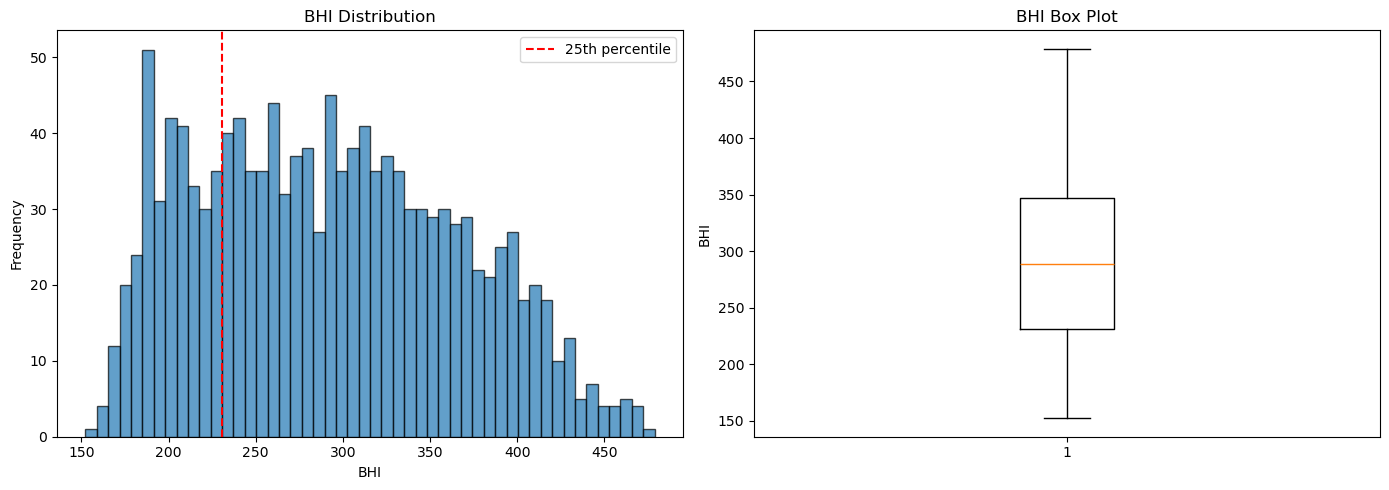

In [9]:
# Visualize BHI distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_full['bhi'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('BHI')
axes[0].set_ylabel('Frequency')
axes[0].set_title('BHI Distribution')
axes[0].axvline(df_full['bhi'].quantile(0.25), color='red', linestyle='--', label='25th percentile')
axes[0].legend()

# Box plot
axes[1].boxplot(df_full['bhi'])
axes[1].set_ylabel('BHI')
axes[1].set_title('BHI Box Plot')

plt.tight_layout()
plt.show()

In [10]:
# ============================================================================
# SPLIT INTO NORMAL vs ANOMALOUS
# ============================================================================

# Define anomaly threshold (e.g., bottom 10% of BHI)
# Adjust this threshold based on your domain knowledge
anomaly_threshold = df_full['bhi'].quantile(0.10)

print(f"Anomaly threshold (10th percentile): {anomaly_threshold:.2f}")

# Split data
df_train = df_full[df_full['bhi'] >= anomaly_threshold].copy()
df_anomaly = df_full[df_full['bhi'] < anomaly_threshold].copy()

print(f"\nTraining (normal) data: {df_train.shape[0]} rows ({df_train.shape[0]/df_full.shape[0]*100:.1f}%)")
print(f"Anomaly data: {df_anomaly.shape[0]} rows ({df_anomaly.shape[0]/df_full.shape[0]*100:.1f}%)")

print(f"\nTraining BHI range: [{df_train['bhi'].min():.2f}, {df_train['bhi'].max():.2f}]")
print(f"Anomaly BHI range: [{df_anomaly['bhi'].min():.2f}, {df_anomaly['bhi'].max():.2f}]")

Anomaly threshold (10th percentile): 194.96

Training (normal) data: 1170 rows (90.0%)
Anomaly data: 130 rows (10.0%)

Training BHI range: [194.98, 478.85]
Anomaly BHI range: [152.35, 194.75]


## 4. Train HT Models

Train regression models for each node with parents

In [11]:
# ============================================================================
# TRAIN HT MODEL
# ============================================================================

# Configure HT
config = HTConfig(
    graph=adj_df, 
    aggregator="max", 
    root_cause_top_k=5,
    model_type='Xgboost'  # Options: LinearRegression, Xgboost, LightGBM, CatBoost, RandomForest
)

# Create HT instance
ht_algo = HT(config)

# Train models
ht_algo.train(df_train, perform_cv=True)

print("\n✅ Training complete!")

🎓 TRAINING MODELS WITH QUALITY ASSESSMENT

📊 Detecting variable types...
   ✓ areaUnitsAsrs: CONTINUOUS
   ✓ areaUnitsPacking: CONTINUOUS
   ✓ areaUnitsPicking: CONTINUOUS
   ✓ areaUnitsPutaway: CONTINUOUS
   ✓ areaUnitsReceiving: CONTINUOUS
   ✓ areaUnitsShipping: CONTINUOUS
   ✓ areaUnitsSortation: CONTINUOUS
   ✓ bhi: CONTINUOUS
   ✓ buildingEffectiveHours: CONTINUOUS
   ✓ buildingOrders: CONTINUOUS
   ✓ buildingRealizedUnits: CONTINUOUS
   ✓ bulkShare: CONTINUOUS
   ✓ effectiveHours: CONTINUOUS
   ✓ forecastUnits: CONTINUOUS
   ✓ keyAssumptionVariance: CONTINUOUS
   ✓ nonconShare: CONTINUOUS
   ✓ ophBuilding: CONTINUOUS
   ✓ ophDept: CONTINUOUS
   ✓ orders: CONTINUOUS
   ✓ realizedUnits: CONTINUOUS
   ✓ shifts: CATEGORICAL (2 classes: [2, 3]...)
   ✓ singlesShare: CONTINUOUS
   ✓ staffedHeadcount: CONTINUOUS
   ✓ staffedHours: CONTINUOUS
   ✓ storagePallets: CONTINUOUS
   ✓ storageUtilizationPct: CONTINUOUS
   ✓ systemDowntimeHrs: CONTINUOUS
   ✓ targetOphBuilding: CATEGORICAL (1 c

In [12]:
# Check model quality
quality_report = ht_algo.get_model_quality_report()
quality_report

{'overall_summary': {'total_nodes': 31,
  'nodes_with_models': 22,
  'regression_nodes': 22,
  'classification_nodes': 0,
  'root_nodes': 8,
  'regression_performance': {'mean_r2': 0.8478,
   'median_r2': 0.9857,
   'min_r2': 0.2222,
   'max_r2': 1.0,
   'mean_rmse': 466.5308}},
 'trust_indicators': {'graph_coverage': 71.0,
  'quality_grade': 'A (Excellent)',
  'recommendations': []},
 'model_breakdown': {'regression_nodes': ['areaUnitsAsrs',
   'areaUnitsPacking',
   'areaUnitsPicking',
   'areaUnitsPutaway',
   'areaUnitsReceiving',
   'areaUnitsShipping',
   'areaUnitsSortation',
   'bhi',
   'buildingEffectiveHours',
   'buildingOrders',
   'buildingRealizedUnits',
   'effectiveHours',
   'keyAssumptionVariance',
   'ophBuilding',
   'ophDept',
   'realizedUnits',
   'staffedHeadcount',
   'staffedHours',
   'storagePallets',
   'storageUtilizationPct',
   'uphBuilding',
   'uphDept'],
  'classification_nodes': [],
  'root_nodes': ['bulkShare',
   'forecastUnits',
   'nonconShare',

## 5. Root Cause Analysis

Identify root causes of poor BHI performance

In [13]:
# ============================================================================
# FIND ROOT CAUSES
# ============================================================================

outvar = 'bhi'

rca_results = ht_algo.find_root_causes(
    df_anomaly, 
    anomalous_metrics=outvar, 
    return_paths=True, 
    adjustment=False
)

print("\n" + "="*70)
print("ROOT CAUSE ANALYSIS RESULTS")
print("="*70)

Finding paths from 5 candidates to bhi...
Found paths for 5 roots.
Calculating enhanced scores for paths...
Normalizing scores (Range: 21.3980 - 282.4623)
Pruning paths with Jaccard threshold > 0.8...
Paths remaining after pruning: 12
RCA finished.

ROOT CAUSE ANALYSIS RESULTS


In [14]:
rca_results

RCAResults(root_cause_nodes=[{'root_cause': 'effectiveHours', 'score': 296.94, 'severity': 5.0}, {'root_cause': 'ophDept', 'score': 91.25, 'severity': 5.0}, {'root_cause': 'uphDept', 'score': 91.06, 'severity': 5.0}, {'root_cause': 'staffedHours', 'score': 26.14, 'severity': 5.0}], root_cause_paths={'effectiveHours': [{'path': ['effectiveHours', 'bhi'], 'score': 1.0, 'path_severity': 5.0}, {'path': ['effectiveHours', 'ophDept', 'bhi'], 'score': 0.95, 'path_severity': 5.0}, {'path': ['effectiveHours', 'uphDept', 'bhi'], 'score': 0.95, 'path_severity': 5.0}, {'path': ['effectiveHours', 'buildingEffectiveHours', 'ophBuilding', 'bhi'], 'score': 0.9, 'path_severity': 4.0}, {'path': ['effectiveHours', 'buildingEffectiveHours', 'uphBuilding', 'bhi'], 'score': 0.9, 'path_severity': 4.0}], 'ophDept': [{'path': ['ophDept', 'bhi'], 'score': 0.25, 'path_severity': 1.0}], 'uphDept': [{'path': ['uphDept', 'bhi'], 'score': 0.25, 'path_severity': 1.0}], 'staffedHours': [{'path': ['staffedHours', 'effe

In [15]:
# ============================================================================
# INITIALIZE SIMULATOR
# ============================================================================

simulator = CausalSimulator(ht_algo)

print("✅ Simulator initialized!")
print(f"   Baseline stats available for {len(simulator.baseline_stats)} nodes")

✅ Simulator initialized!
   Baseline stats available for 31 nodes


In [23]:
# ============================================================================
# FIND BEST INTERVENTION
# ============================================================================

# Target: Improve BHI by 15%
target_improvement = 10.0

print(f"\n🎯 Finding best intervention to improve BHI by {target_improvement}%...\n")

best_intervention = simulator.find_best_intervention(
    outcome_node='areaUnitsReceiving',
    target_change=target_improvement,
    candidate_nodes=None,  # Will test all ancestors of BHI
    max_intervention_pct=30,  # Maximum change allowed
    allow_combinations=True,  # Test 2-node combinations
    tolerance=5.0,  # Accept ±3% error
    max_search_iterations=15,
    min_model_quality=0.5,
    enable_uncertainty=True
)

print("\n✅ Search complete!")


🎯 Finding best intervention to improve BHI by 10.0%...


🎯 GRADE-A INTERVENTION SEARCH (v2.0)
Target: +10.0% change in areaUnitsReceiving
Tolerance: ±5.0% points
Max intervention: ±30%
Acceptable range: +5.0% to +15.0%

📊 Pre-flight: Checking model quality...

🔍 Testing 3 candidates with DIRECT search...

   Testing: realizedUnits
      ✓ Found: +10.0% → +7.1% (error: 2.9%)
      📊 90% CI: [-13.9%, +28.2%]
      ✅ VALIDATED within tolerance

   Testing: orders
      ✓ Found: +15.0% → +11.7% (error: 1.7%)
      📊 90% CI: [-9.4%, +32.7%]
      ✅ VALIDATED within tolerance

   Testing: singlesShare
      ⚙️  Refining (current error: 9.3%)...
      📊 90% CI: [-20.4%, +21.7%]
      ⚠️  Error 9.3% exceeds tolerance (5.0%)

🔗 Testing optimized two-node combinations...
      ✓ Combo 1: realizedUnits (+10.0%) + orders (+5.0%) → +7.1%
      ✓ Combo 2: realizedUnits (+10.0%) + singlesShare (+5.0%) → +7.1%
      ✓ Combo 3: orders (+10.0%) + singlesShare (+10.0%) → +12.0%

✅ SEARCH COMPLETE

Resul

In [24]:
# Show all tested options
print("\n" + "="*70)
print("ALL TESTED INTERVENTIONS (Top 10)")
print("="*70)

all_options = best_intervention['all_options'][:10]

results_df = pd.DataFrame([{
    'Type': opt['intervention_type'],
    'Variables': ', '.join(opt['nodes']),
    'Effect': f"{opt['actual_effect']:+.1f}%",
    'Error': f"{opt['error_from_target']:.1f}%",
    'Within_Tol': '✅' if opt['within_tolerance'] else '❌',
    'Confidence': f"{opt['confidence']:.0%}",
    'Feasible': '✅' if opt['feasible'] else '❌'
} for opt in all_options])

results_df


ALL TESTED INTERVENTIONS (Top 10)


,Type,Variables,Effect,Error,Within_Tol,Confidence,Feasible
0,single,orders,+11.7%,1.7%,✅,92%,✅
1,single,realizedUnits,+7.1%,2.9%,✅,90%,✅
2,combination,"orders, singlesShare",+12.0%,2.0%,✅,75%,✅
3,combination,"realizedUnits, orders",+7.1%,2.9%,✅,75%,✅
4,combination,"realizedUnits, singlesShare",+7.1%,2.9%,✅,75%,✅
5,single,singlesShare,+0.7%,9.3%,❌,65%,✅


In [25]:
# ============================================================================
# TEST SPECIFIC INTERVENTION
# ============================================================================

# Example: What if we reduce system downtime by 25%?
test_intervention = {'realizedUnits': {'pct_change': -25}}

result = simulator.simulate_intervention(
    interventions=test_intervention,
    outcome_nodes='bhi'
)

print("\nIntervention: Reduce systemDowntimeHrs by 25%")
print(f"\nEffect on BHI:")
print(f"  Baseline: {result['outcome_effects']['bhi']['no_intervention']:.2f}")
print(f"  With intervention: {result['outcome_effects']['bhi']['with_intervention']:.2f}")
print(f"  Absolute change: {result['outcome_effects']['bhi']['absolute_effect']:+.2f}")
print(f"  Percentage change: {result['outcome_effects']['bhi']['pct_effect']:+.1f}%")


Intervention: Reduce systemDowntimeHrs by 25%

Effect on BHI:
  Baseline: 308.87
  With intervention: 254.87
  Absolute change: -54.00
  Percentage change: -17.5%
